## Regression with Google Maps dataset

The  task is to find one corner (vertex) of a building in each image. The data comes from screenshots of Google Maps

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting and converting the data

In [3]:
path = untar_data('perimeter_data')

In [55]:
fname = '1.jpg'

In [56]:
def img2txt_name(f): return path/f'{str(f)[:-4]}.txt'

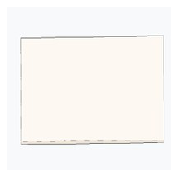

In [57]:
img = open_image(path/fname)
img.show()

In [58]:
coords = np.genfromtxt(img2txt_name(fname), skip_header=0,delimiter=",")
coords

array([[ 17.,  38.],
       [189.,  36.],
       [189., 165.],
       [ 20., 167.]])

In [59]:
def switch_x_y(coords):
    for i in range(0,len(coords)):
        coords[i][0], coords[i][1]= coords[i][1],coords[i][0]
    return coords

def get_coords(f):
    coords = np.genfromtxt(img2txt_name(f), skip_header=0,delimiter=",")

    coords = switch_x_y(coords)

    return tensor(coords)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [60]:
get_coords(fname)

tensor([[ 38.,  17.],
        [ 36., 189.],
        [165., 189.],
        [167.,  20.]], dtype=torch.float64)

In [61]:
img.size

torch.Size([200, 200])

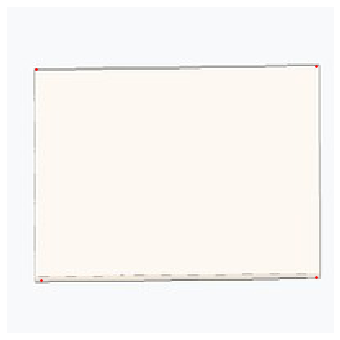

In [62]:
coords = get_coords(fname)

img.show(y=get_ip(img, coords), figsize=(6, 6))

## Creating a dataset

In [101]:

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='test')
        .label_from_func(get_coords)
        .transform(size=(200,200))
        .databunch(bs = 5,num_workers = 0).normalize()
      )




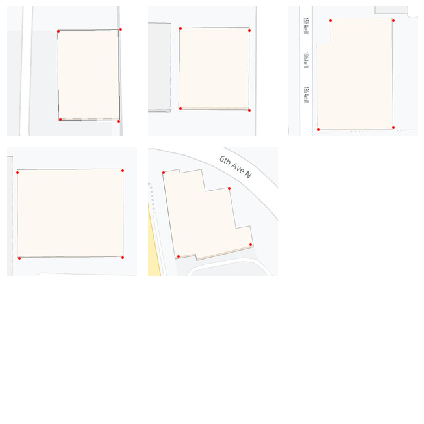

In [102]:
data.show_batch(7, figsize=(6,6))

## Train model

In [103]:
learn = cnn_learner(data, models.resnet34)

In [104]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [105]:
lr = 1e-2

In [121]:
learn.fit_one_cycle(100, slice(lr))

epoch,train_loss,valid_loss,time
0,0.323898,0.098285,00:05
1,0.328003,0.093105,00:05
2,0.336334,0.095131,00:06
3,0.338822,0.094404,00:06
4,0.337143,0.092237,00:05
5,0.335370,0.088512,00:06
6,0.340217,0.086220,00:06
7,0.342483,0.088312,00:06
8,0.344882,0.091203,00:06
9,0.336601,0.090041,00:06


In [122]:
learn.save('stage-1')

In [123]:
learn.load('stage-1');

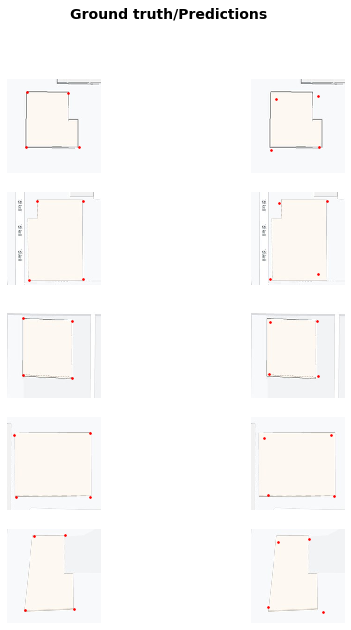

In [128]:
learn.show_results(ds_type=DatasetType.Train, rows=8, figsize=(8,10))

## Data augmentation

In [116]:
tfms = get_transforms(max_rotate=20)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='test')
        .label_from_func(get_coords)
        .transform(tfms, tfm_y=True, size=(200,200))
        .databunch(bs = 5,num_workers = 0).normalize()
       )


# data = (PointsItemList.from_folder(path)
#         .split_by_valid_func(lambda o: o.parent.name=='test')
#         .label_from_func(get_coords)
#         .transform(size=(200,200))
#         .databunch(bs = 5,num_workers = 0).normalize()
#       )



You can deactivate this warning by passing `no_check=True`.


/usr/local/lib/python3.7/site-packages/fastai/basic_data.py:261: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access these elements in self.train_ds: 1,15,8
  warn(warn_msg)


RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'mat2' in call to _th_mm

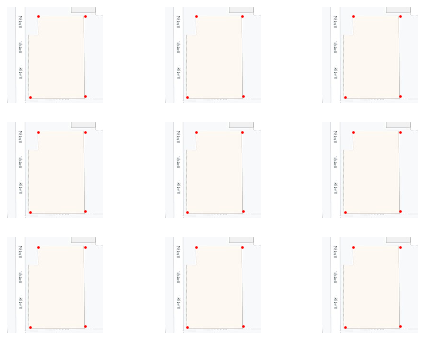

In [114]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))